<a href="https://colab.research.google.com/github/Ann-pixel/ML-dog-vision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End to end Multiclass Dog-breed classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlowHub

### 1. Problem
Identifying the breed of a dog, given a picture of that dog.


### 2. Data
The data we are using is from Kaggle's dogbreed identification classification.
https://www.kaggle.com/c/dog-breed-identification#

### 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
The evaluation is a file wiht prediction probabilities for each dog breed of each test image.

### 4. Features
Some information about the data.
* We're dealing with images(unstructured data) so it is probably best we use deep learning/transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10k+ images in the train set(images have labels.)
* There are around 10k+ images in the test set (images have no labels-we predict them)

In [ ]:
#unzip zipped file using code.
# !unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision"

### Getting our workspace ready
* import TensorFlow 2.x
* import TensorFlow Hub
* Make sure we're using a GPU.

In [1]:
#import tensorflow into our google colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version",tf.__version__ )
print("TF Hub version", hub.__version__ )

#Check for GPU availablility
print("GPU", "available!!!" if tf.config.list_physical_devices("GPU") else "not available")

TF version 2.7.0
TF Hub version 0.12.0
GPU available!!!


## Gettting our data ready(turing into Tensors)
With all machine learning models, our data has to be in numerical format.

Lets start by accessing our data and checking out our labels

In [2]:
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     2f854899d933d9cbb9d262fff843dd8a  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


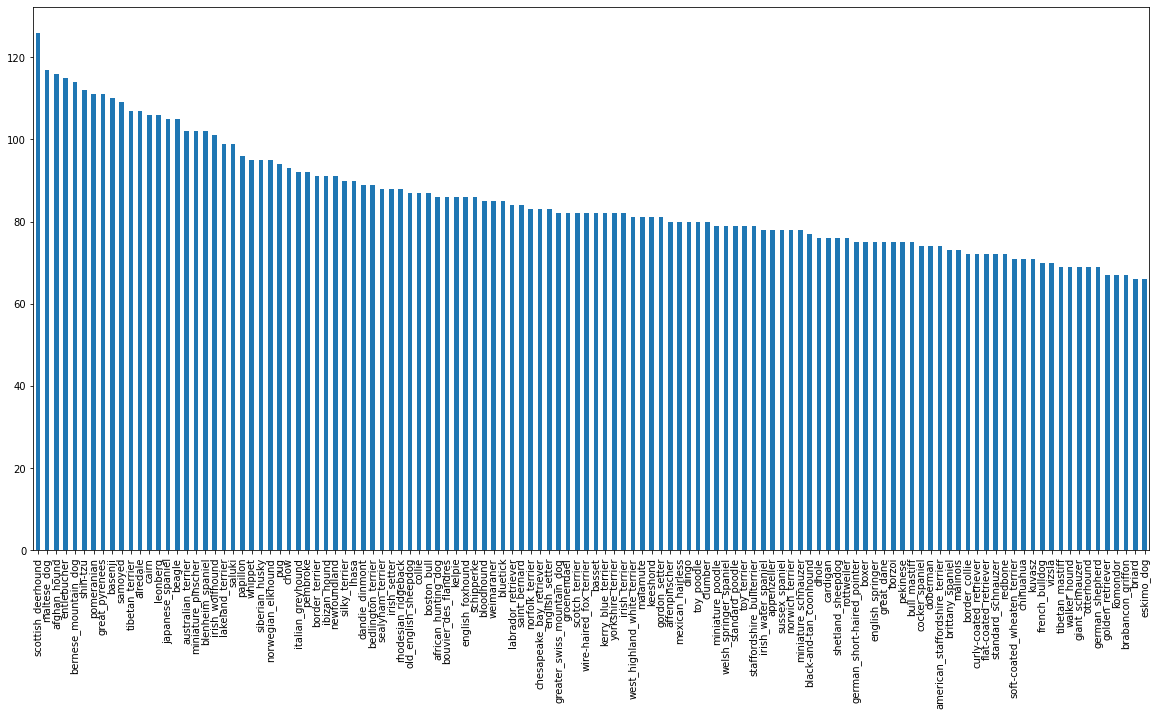

In [3]:
#how many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

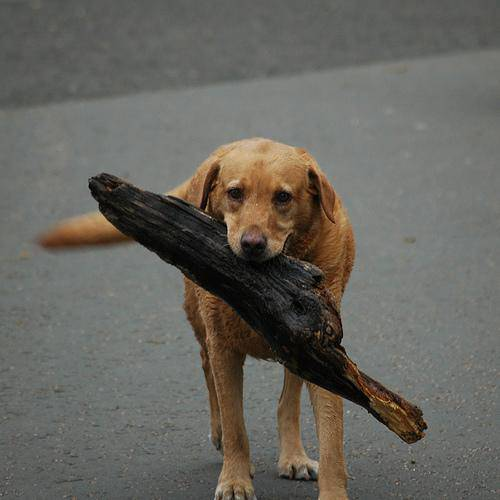

In [4]:
#Lets view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels
lets get a list of all our images and their path names

In [5]:
#Create a pathname from image's ID
filenames = ["drive/MyDrive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [7]:
#Check whether number of filenames matches the number of actual image files.
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("filenames match actual files.")
else:
  print("filenames dont match the actual files")

filenames match actual files.


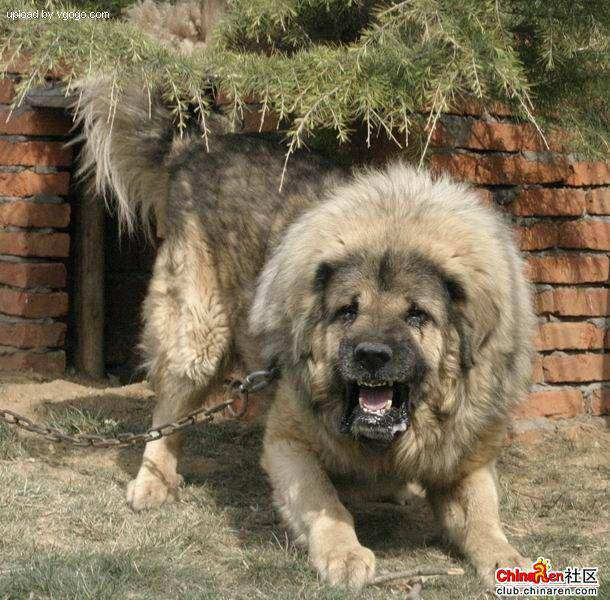

In [9]:
Image(filenames[9000])

Since we have our file paths in a list. Let's prepare our labels.

In [11]:
import numpy as np
labels= np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
len(labels)

10222

In [16]:
# See if the number of labels matches the number of files (a workaround to find missing data for unstructured data.)
if len(labels) == len(filenames):
  print("Number of filenames matches the number of labels! no missing data!")
else:
  print("Labels dont match the number of filenames. There must be some missing data!")

Number of filenames matches the number of labels! no missing data!


In [21]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [22]:
len(unique_breeds)

120

In [23]:
#Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [29]:
#Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels), len(labels)

(10222, 10222)

In [30]:
#Example: Turning boolean array into integers
print(labels[0]) #original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in the boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where sample label occurs.

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [31]:
print(labels[2]) #name of the breed
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
